## Projeto Kobe - Engenharia de Machine learning 

Aluna: Isabelle R.V. Melo

Neste projeto serão implementados os conhecimentos de AutoML, Engenharia de Machine learning e visualização para o conjunto de dados de arremessos e jogos do famoso jogador Black Mamba. São utilizadas bibliotecas como Mlflow, Pycaret, Streamlit, Scikit-learn entre outras, que serão melhores discutidos ao longo do projeto. 

A intenção é tornar possível o deployment de um projeto de Machine learning havendo a reprodutibilidade de experimentos, bem como monitoramento e acesso de visualização de resultados.

Link github: https://github.com/misabellerv/ProjectKobe

## Diagrama de um projeto de Engenharia de Machine learning

Em linhas gerais, aqui está o diagrama de um projeto de EngML. Não basta apenas preparar dados, treinar e testar modelos (modelagem), fazer tunagem de hiperparâmetros e gerar métricas. É preciso que os experimentos sejam reprodutíveis, possuam monitoramento, haja um rastreamento eficiente e sua visualização de resultados seja acessível. 

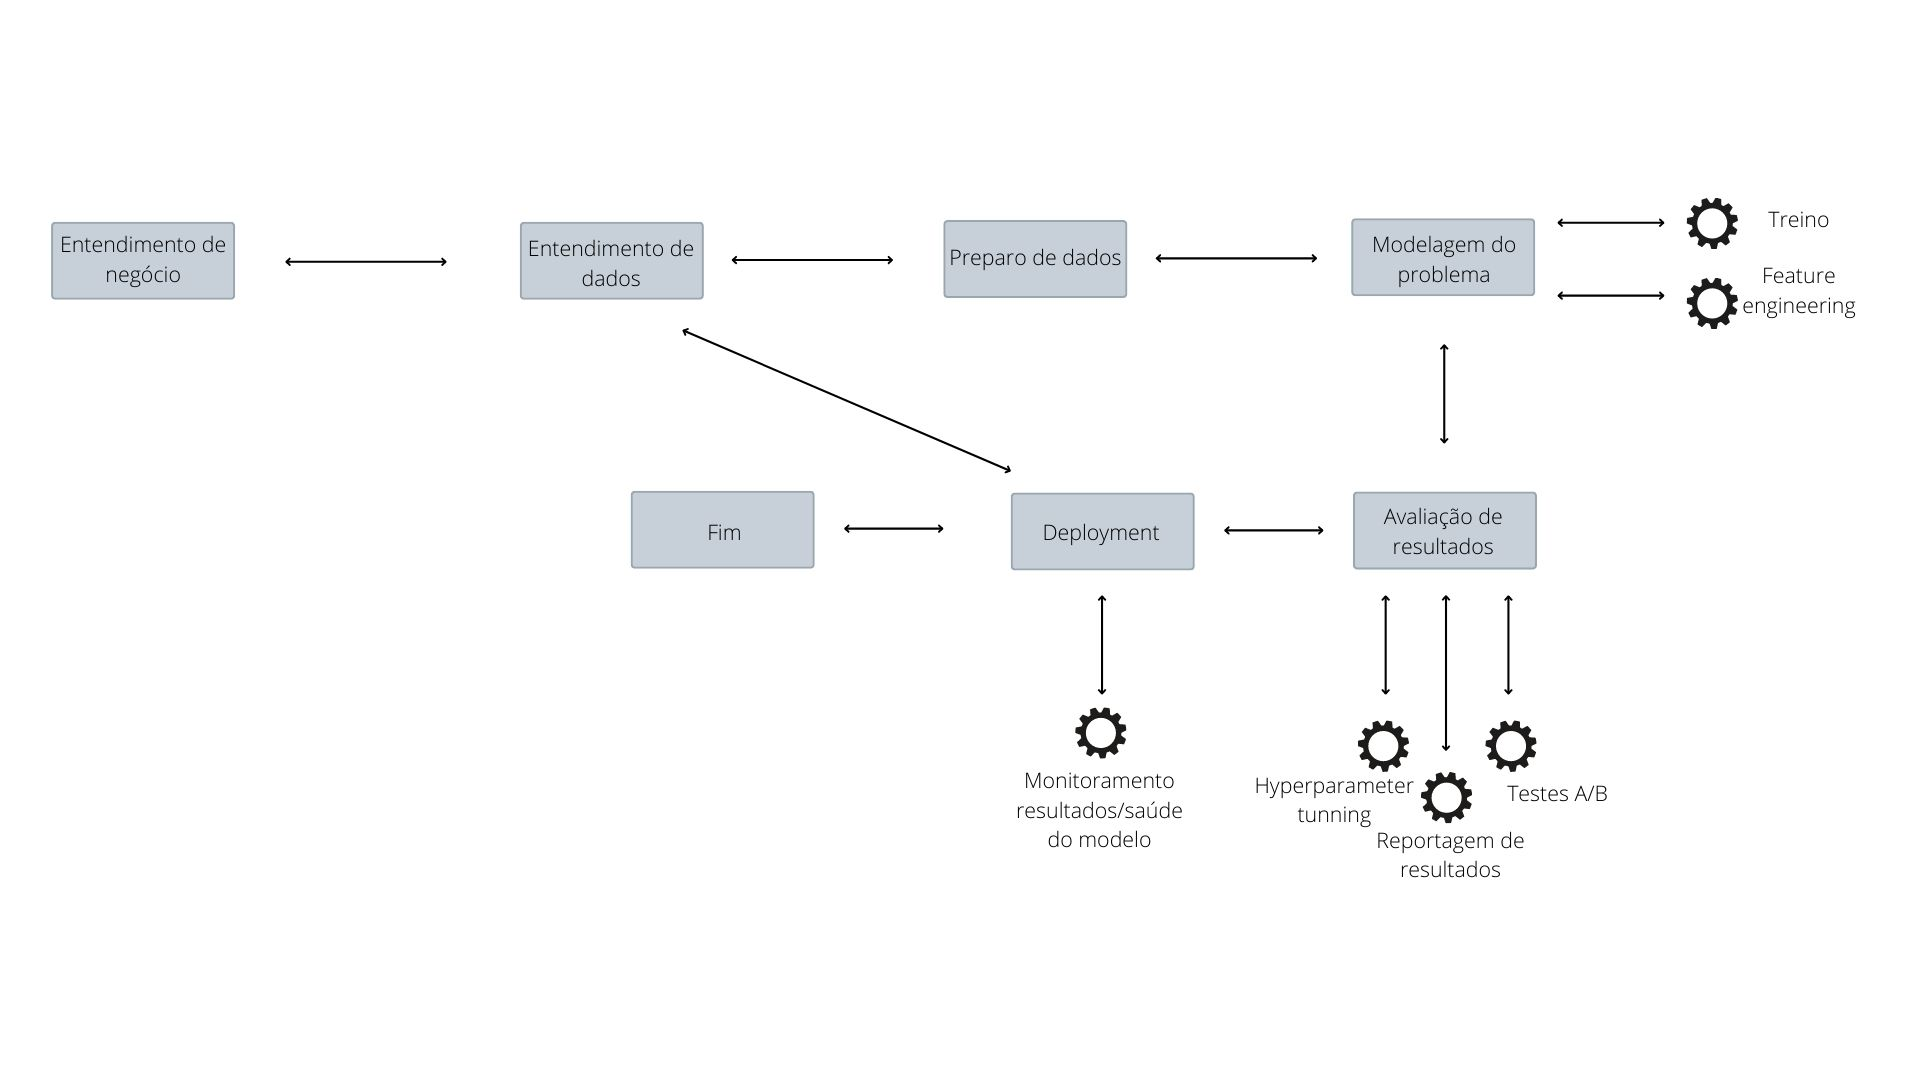

## Importância das ferramentas MLflow, Pycaret, Scikit-learn e Streamlit durante as etapas do projeto

No treinamento de dados, o MLflow é responsável pelo registro dos dados treinados e experimentos performados, salvando artefatos. O pycaret encontra o melhor modelo e gera os artefatos. O scikit-learn gera as métricas. 

No rastreamento, o MLflow é responsável pela criação de APIs para os modelos exectuados, o pycaret engloba a configuração dos dados que foram registrados no pipeline anterior.

No monitoramento, o MLflow registra os treinos e os experimentos da base, o pycaret realiza os testes do modelo que foi préviamente registrado no pipeline com MLflow.

Na atualização, novamente o MLflow cria API e modelos, o pycaret cria os artefatos, engloba as métricas geradas pelo scikit-learn e os parâmetros dos modelos. o scikit-learn faz o carregamento dos modelos gravados no MLflow.

No provisionamento, o MLflow leva o código à etapa de produção.

## Importando as bibliotecas

In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import linear_model, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from pycaret.classification import *
import pycaret.classification as pc

import seaborn as sn

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10
np.random.seed(SEED)

In [2]:
mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

registered_model_name = 'projeto_kobe'
min_precision = 0.7
model_version = -1
nexamples = 4

## Pipeline de desenvolvimento e preparação

Em uma solução de ML, é essencial o uso de pipelines pois estes encapsulam as melhores práticas aprendidas para produzir um modelo de ML permitindo todo o ecossistema de equipe excutar o projeto em escala. 
Neste primeiro pipeline realiza-se a preparação dos dados, onde se carrega o dataset separando para a parte de execução do projeto para os dois tipos de feature "shot_type". Exclui-se as linhas com valores NaN pois podem haver problemas na execução da modelagem em treino de modelos para quando houver um valor não definido.
Aqui faz-se a divisão de treino e teste na proporção 80/20, tendo assim um pipeline estrutuado dos dados que serão usados posteriormente.

In [7]:
### desenvolvimento

mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

In [9]:
### preparação dados

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    
    df = pd.read_csv('../Data/Raw/kobe_dataset.csv',sep=',')
    
    target_col = 'shot_made_flag'
    
    df_2pt = df[df['shot_type'] == '2PT Field Goal']
    df_2pt = df_2pt[['lat','lon','minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']]
    
    ##############################################################################################################
      
    df_3pt = df[df['shot_type'] == '3PT Field Goal']
    df_3pt = df_3pt[['lat','lon','minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']]
    
    # drop nas colunas vazias
    
    df_2pt = df_2pt.dropna()
    df_3pt = df_3pt.dropna()
    test_size = 0.2
    
    # train test split 80/20
    
    xtrain, data_operation, ytrain, ytest = model_selection.train_test_split(df_2pt, 
                                                                            df_2pt[target_col],
                                                                            test_size=test_size)
    
    data_novelty = df_3pt.copy()

    xtrain.to_parquet('../Data/Processed/data_filtered.parquet')
    data_operation.to_parquet('../Data/Processed/base_8020.parquet')
    data_novelty.to_parquet('../Data/Processed/base_kobe_novidade.parquet')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("test_size", test_size)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_dev", df_2pt.shape[0])
    mlflow.log_metric("data_operation", data_operation.shape[0])
   
    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'xtrain {xtrain.shape}')
print(f'data_operation {data_operation.shape}')
print(f'Columns: {df_2pt.columns}')
print(f'Value counts for df:')

== Bases de Dados ==
xtrain (16228, 7)
data_operation (4057, 7)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'shot_distance', 'shot_made_flag'],
      dtype='object')
Value counts for df:


## Pipeline de treinamento

Neste pipeline são escolhidos os modelos a serem aplicados ao conjunto de dados e realiza-se o treinamento destes. Utilizamos 2 métricas principais: a log_loss e a métrica f1-score. É feita uma validação cruzada estratificada com 10 folds e a comparação dos resultados obtidos pelos modelos. Com isso, geramos os artefatos dos modelos como AUC, Matriz de confusão, Importância de features, curva precisão-recall, Limite de Threshold e cuva de validação, que serão mostrados logo em seguida. São testados os modelos de regressão logística e decision trees visto que temos um problema de classificação.

In [10]:
with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treino'):
    
    models = ['lr','dt']
    probability_threshold = 0.5
    cross_validation = True
    fold_strategy = 'stratifiedkfold',
    fold = 10

    # train/test
    s = pc.setup(data = df_2pt, 
                 target = target_col,
                 train_size=0.8,
                 silent = True,
                 fold_strategy = 'stratifiedkfold',
                 fold = fold,
                 log_experiment = True, 
                 experiment_name = experiment_name, 
                 log_plots = True,
                 verbose=False
                )
    #bestmodel = pc.create_model(model_name,cross_validation = cross_validation,probability_threshold=probability_threshold)
    add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)
    bestmodels = pc.compare_models(include = models, sort='f1',n_select=2)
    
    # Log do run, e nao do modelo respectivo
    classification_plots = [ 'auc','pr','confusion_matrix',
    #                          'error', 'class_report', 
                            'threshold',
                             'learning','vc','feature',
                            
                           ]
    for plot_type in classification_plots:
        print('=> Aplicando plot ', plot_type)
        try:
            artifact = pc.plot_model(bestmodels[0], plot=plot_type, save=True, use_train_data=False)
            mlflow.log_artifact(artifact)
        except:
            print('=> Nao possivel plotar: ', plot_type )
            continue

    pred_holdout = pc.predict_model(bestmodels[0])
    pred_holdout_sec = pc.predict_model(bestmodels[1])
    mlflow.log_metrics({"log loss Arvore":  log_loss(ytest, pred_holdout['Label']),
                       "f1 Arvore": f1_score(ytest, pred_holdout['Label'].astype(float)),
                       })
    
    mlflow.log_metrics({"log loss LR":  log_loss(ytest, pred_holdout_sec['Label']),
                       "f1 LR": f1_score(ytest, pred_holdout_sec['Label'].astype(float)),
                       })
    pc.save_model(bestmodels[0], f'../Data/Modeling/{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = pc.load_model(f'../Data/Modeling/{registered_model_name}')


mlflow.end_run()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5507,0.5341,0.5879,0.5373,0.5615,0.1027,0.1031,15.5201


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Logistic Regression,0.5706,0.5936,0.4660,0.5756,0.5150,0.1374,0.1399,14.8304


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Os artefatos estão mostrados abaixo com suas respectivas explicações

A métrica AUC da curva ROC registra a taxa de verdadeiros positivos vs a de falsos positivos. Normalmente a que se sobrepõe possui uma área abaixo da curva maior e representa um modelo que seja "melhor".

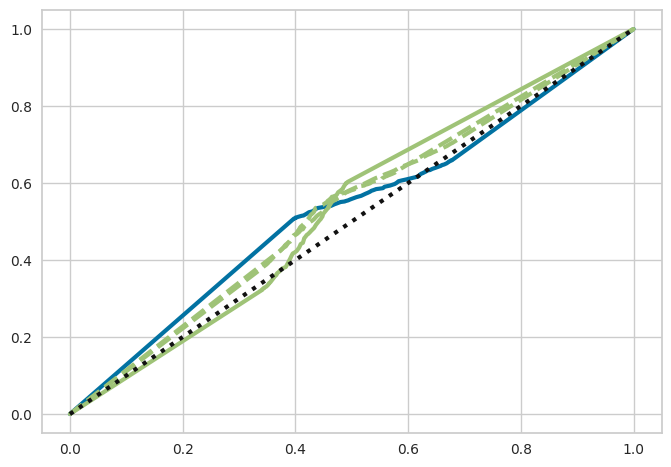

Como estamos trabalhando com a classificação binária, é conveniente avaliar as métricas a partir do olhar da matriz de confusão, que enumera os Verdadeiros positivos e Verdadeiros negativos, respectivamente na diagonal, e os Falsos positivos e Falsos negativos, nas entradas não diagonais da matriz. Isso permite cálculo de f1, log_los, precisão, acurácia etc, para que sejam avaliados os modelos da perspectiva especialista. Pelas métricas avaliadas, o melhor modelo é o decision tree e os artefatos são referentes ao mesmo.

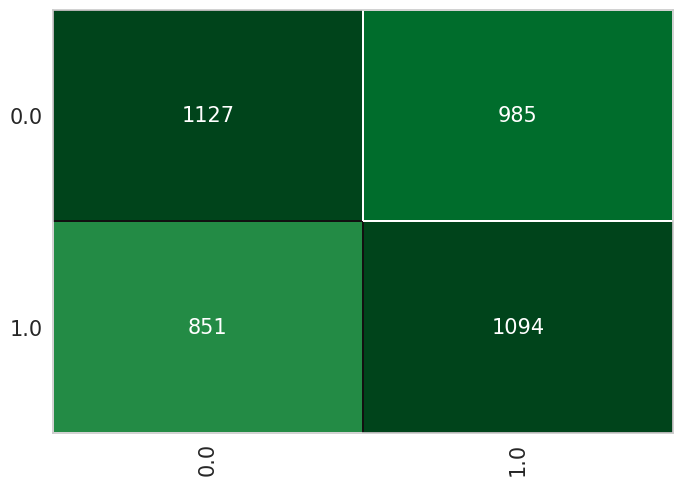

O diagrama de Importância de features representa quais foram as features mais relevantes para o problema de classificação. Como podemos ver, as features 'lon' e 'lat' foram as mais relevantes, seguindo de 'shot_distance'.

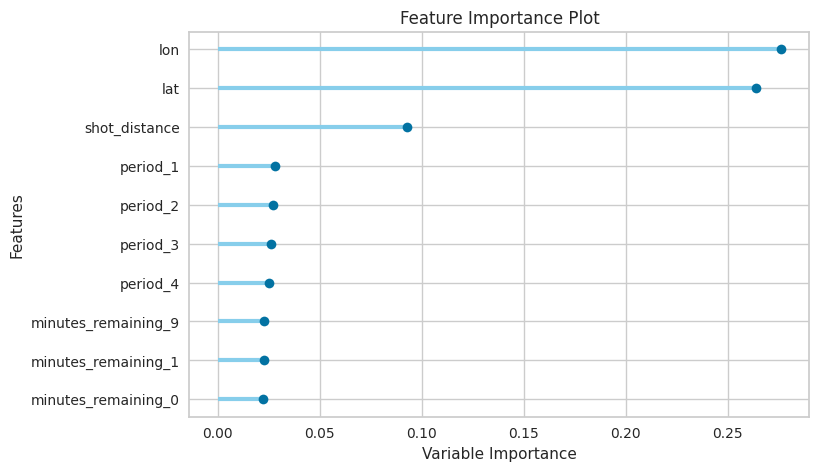

Na curva de aprendizado, podemos verificar os valores da métrica desejada pelo usuário, a medida que se aumenta a base de dados.

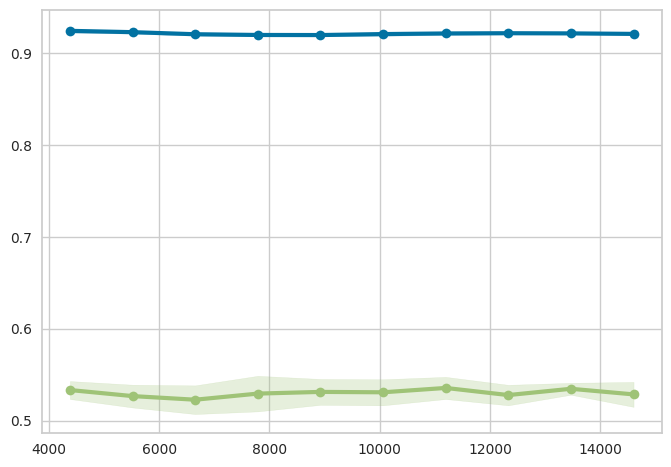

A curva de precision-recall é uma alternativa a curva ROC-AUC, quando se é mais necessário avaliar as métricas de precisão e/ou recall (pensemos no exemplo do trabalho anterior em detecção de câncer, é mais relevante classificar todo câncer, do que classificar toda lesão benigna)

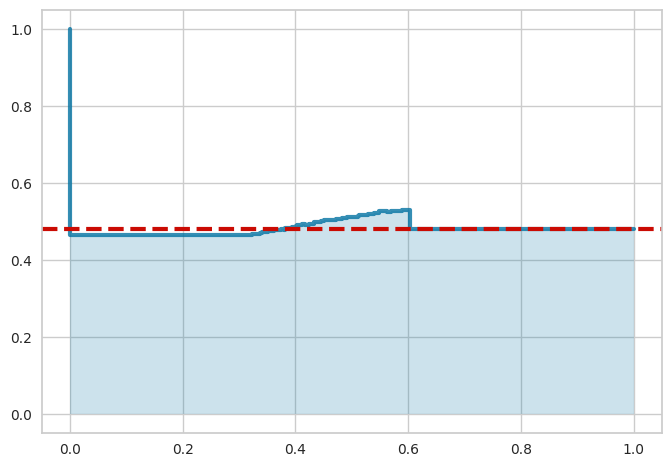

A figura de Threshold indica o tradeoff entre as entradas da matriz de confusão a medida que se aumenta o threshold na distribuição de probabilidades de classes.

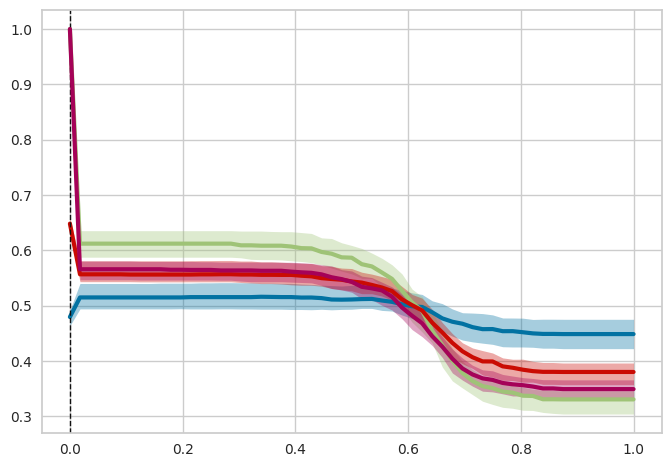

A curva de validação é feita durante a validação cruzada, em que se avalia a diferença de performance entre treino e teste do conjunto de validação. À medida que se aumenta a compelxidade do modelo, temos que os dados de treino aumentam muito suas performances, mas os de teste não necessariamente aumentam, e chegam até a diminuir, como por exemplo no último ponto do gráfico onde claramente há um overfitting. 

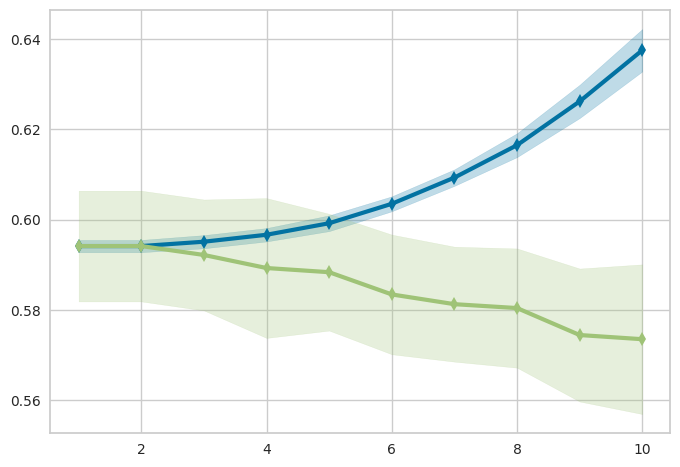

O treino e teste afetam o resultado final da seguinte maneira: quanto maior for o treino, mais o algoritmo vai aprender o padrão dos dados, e menos vai ser possível de generalizar em um conjunto desconhecido (conhecido como overfitting). Um conjunto de treino muito pequeno fará com que o algoritmo não caputre bem a distribuição e padrões de dados (conhecido como underfitting). É necessário um balanço entre treino e teste, por isso é escolhida a proporção 80/20 mas há artigos em que se utiliza 75/25. 

## Rastreamento dos dados

Assinatura do modelo e versão

In [12]:
from mlflow.tracking import MlflowClient
mlflow.set_tracking_uri("sqlite:///mlruns.db")

registered_model_name = 'modelo_kobe'
model_version = -1 # recuperar a ultima versao
nexamples = 4


# Assinatura do Modelo Inferida pelo MLFlow

model_features = list(df_2pt.drop(target_col, axis=1).columns)
inf_signature = infer_signature(df_2pt[model_features], model_pipe.predict(df_2pt))

# Exemplo de entrada para o MLmodel

input_example = {x: df_2pt[x].values[:nexamples] for x in model_features}

# Log do pipeline de modelagem do sklearn e registrar como uma nova versao

# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
     sk_model=model_pipe,
     artifact_path="sklearn-model",
     registered_model_name=registered_model_name,
     signature = inf_signature,
     input_example = input_example
 )
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name)[-1].version
# Registrar o modelo como staging
client.transition_model_version_stage(
     name=registered_model_name,
     version=model_version, # Verificar com usuario qual versao
     stage="Staging"
)
mlflow.end_run()

Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/10 15:26:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 2
Created version '2' of model 'modelo_kobe'.


In [17]:
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
!mlflow models serve -m "models:/modelo_kobe/Staging" --no-conda -p 5002

^C


Podemos avaliar para o df_3pt como foi pedido no moodle e comparar a aderência para ambos modelos dos diferentes datasets.

In [18]:
import requests
host = 'localhost'
port = '5002'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json'}

http_data = data_operation.drop(target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)
data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]
data_operation.to_parquet('../Data/Modeling/modelo_kobe_operacao.parquet')

print(metrics.classification_report(data_operation[target_col], data_operation['operation_label']))

http_data = df_3pt.drop(target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

df_3pt.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(df_3pt[target_col], df_3pt['operation_label']))

print(f'Value counts df_kobe_3pt: {df_3pt[target_col].value_counts()}')

              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84      2133
         1.0       0.80      0.90      0.84      1924

    accuracy                           0.84      4057
   macro avg       0.85      0.84      0.84      4057
weighted avg       0.85      0.84      0.84      4057

              precision    recall  f1-score   support

         0.0       0.67      0.54      0.60      3630
         1.0       0.33      0.45      0.38      1782

    accuracy                           0.51      5412
   macro avg       0.50      0.50      0.49      5412
weighted avg       0.56      0.51      0.53      5412

Value counts df_kobe_3pt: 0.0    3630
1.0    1782
Name: shot_made_flag, dtype: int64


Para o caso do df_2pt temos um modelo que não gera métricas excelentes, (f1 e log_loss), sendo o f1 abaixo de 50%, entretanto comparando os dois modelos encontrados pode-se dizer que é aderente a base de dados.
Já para o caso df_3pt, os valores de shot_distances são diferentes apresentando para os modelos dois f1 scores distantes entre si, como podemos ver acima.

In [19]:
import requests
host = 'localhost'
port = '5002'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json'}

http_data = data_operation.drop(target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [21]:
http_data = df_3pt.drop(target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

df_3pt.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]


print(f'Métricas retornadas pelo modelo: ')

Métricas retornadas pelo modelo: 


## Monitoramento de dados

Para esta etapa há pipleines para aprovação - revalidação de amostras - alarme de desvio - alarme de retreino - e monitoramento da base de operação

In [22]:
## aprovação

min_accuracy = 0.5
model_version = -1 # recuperar a ultima versao


with mlflow.start_run(experiment_id=experiment_id, run_name = 'AprovacaoModelo'):
    pred_holdout = pc.predict_model(bestmodels[0])
    acc = metrics.accuracy_score(pred_holdout[target_col], pred_holdout['Label'])
    if acc > min_precision:
        print(f'=> Aceito o modelo com precisão {acc} (min: {min_accuracy})')
        pred_holdout.to_parquet('../Data/Processed/modelo_kobe_teste.parquet')
        
        # Assinatura do Modelo Inferida pelo MLFlow
        
        model_features = list(df.drop(target_col, axis=1).columns)
        inf_signature = infer_signature(df[model_features], model_pipe.predict(df))
        # Exemplo de entrada para o MLmodel
        input_example = {x: df[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example
        )
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        client = MlflowClient()
        if model_version == -1:
            model_version = client.get_latest_versions(registered_model_name)[-1].version
        # Registrar o modelo como staging
        client.transition_model_version_stage(
            name=registered_model_name,
            version=model_version, # Verificar com usuario qual versao
            stage="Staging"
        )
    else:
        print(f'=> Rejeitado o modelo com precisão {acc} (min: {min_accuracy})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_accuracy)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5507,0.5341,0.5879,0.5373,0.5615,0.1027,0.1031,15.5201


=> Rejeitado o modelo com precisão 0.5506531920138032 (min: 0.5)


In [24]:
## revalidação 

min_samples_control = 150

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    data_operation = pd.read_parquet('../Data/Modeling/modelo_kobe_operacao.parquet')

    data_control = data_operation.sample(min_samples_control, random_state=SEED)
    data_control.to_parquet('../Data/Processed/modelo_kobe_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    print(metrics.classification_report(data_control[target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[target_col], data_control['operation_label'])
    specificity = cm[0,0] / cm.sum(axis=1)[0]
    sensibility = cm[1,1] / cm.sum(axis=1)[1]
    precision   = cm[1,1] / cm.sum(axis=0)[1]
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87        69
         1.0       0.87      0.93      0.90        81

    accuracy                           0.89       150
   macro avg       0.89      0.88      0.89       150
weighted avg       0.89      0.89      0.89       150



In [23]:
## alarme 

mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 4}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_control):    
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Distancia')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

In [25]:
## alarme de retreino

def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[target_col], testset['Label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

== ALARME DE RETREINAMENTO - BASE CONTROLE ==
	=> especificidade de teste 0.51496138996139 e de controle 0.8405797101449275
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.5879093198992443 e de controle 0.9259259259259259
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> precisao de teste 0.537292817679558 e de controle 0.872093023255814
	=> MODELO OPERANDO DENTRO DO ESPERADO
==> RETREINAMENTO NAO NECESSARIO


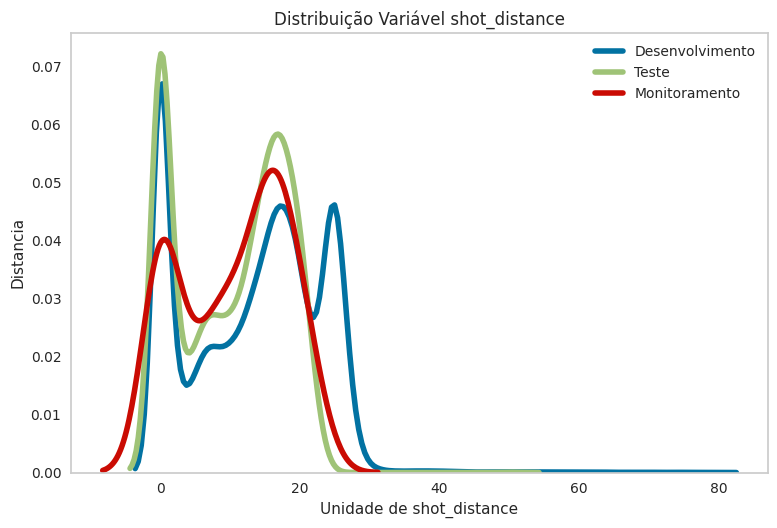

In [26]:
## monitoramento base

print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoOperacao'):
    data_control = pd.read_parquet('../Data/Processed/modelo_kobe_controle.parquet')
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'shot_distance' # 'alcohol'
    data_drift_alarm(var_name, df, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

mlflow.end_run()  

## Atualização dos dados

== ALARME DE RETREINAMENTO - BASE NOVIDADE ==
	=> especificidade de teste 0.51496138996139 e de controle 0.5449035812672176
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.5879093198992443 e de controle 0.4483726150392817
	=> MODELO OPERANDO FORA DO ESPERADO
	=> precisao de teste 0.537292817679558 e de controle 0.3259893920848633
	=> MODELO OPERANDO FORA DO ESPERADO
==> RETREINAMENTO NECESSARIO


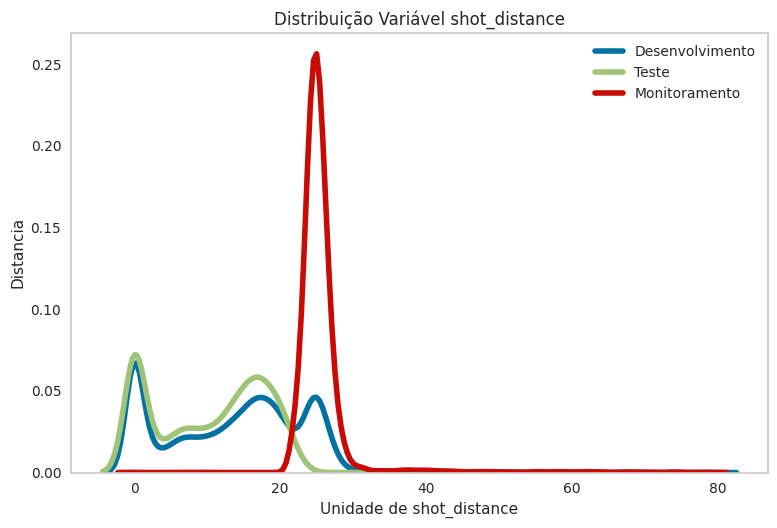

In [27]:
print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_kobe/Staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('../Data/Processed/base_kobe_novidade.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty)
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'shot_distance' # 'alcohol'
    data_drift_alarm(var_name, df, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run()  

## Pondo o modelo em produção

In [28]:
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
     sk_model=model_pipe,
     artifact_path="sklearn-model",
     registered_model_name=registered_model_name,
     signature = inf_signature,
     input_example = input_example
 )
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name).version
# Registrar o modelo como staging
client.transition_model_version_stage(
     name=registered_model_name,
     version=client.get_latest_versions(registered_model_name).version, # Verificar com usuario qual versao
     stage="Production"
)
mlflow.end_run()

Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/10 15:29:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 3
Created version '3' of model 'modelo_kobe'.


AttributeError: 'list' object has no attribute 'version'